In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [9]:
ls

1-all-client.txt     Run 2_cdf_plots.png  md5sum.o
1-small-client.txt   client*              server_img*
RUN1.txt             images_all/          server_img.o
RUN2.txt             images_small/        timelib.o
Run 1_cdf_plots.png  imglib.o


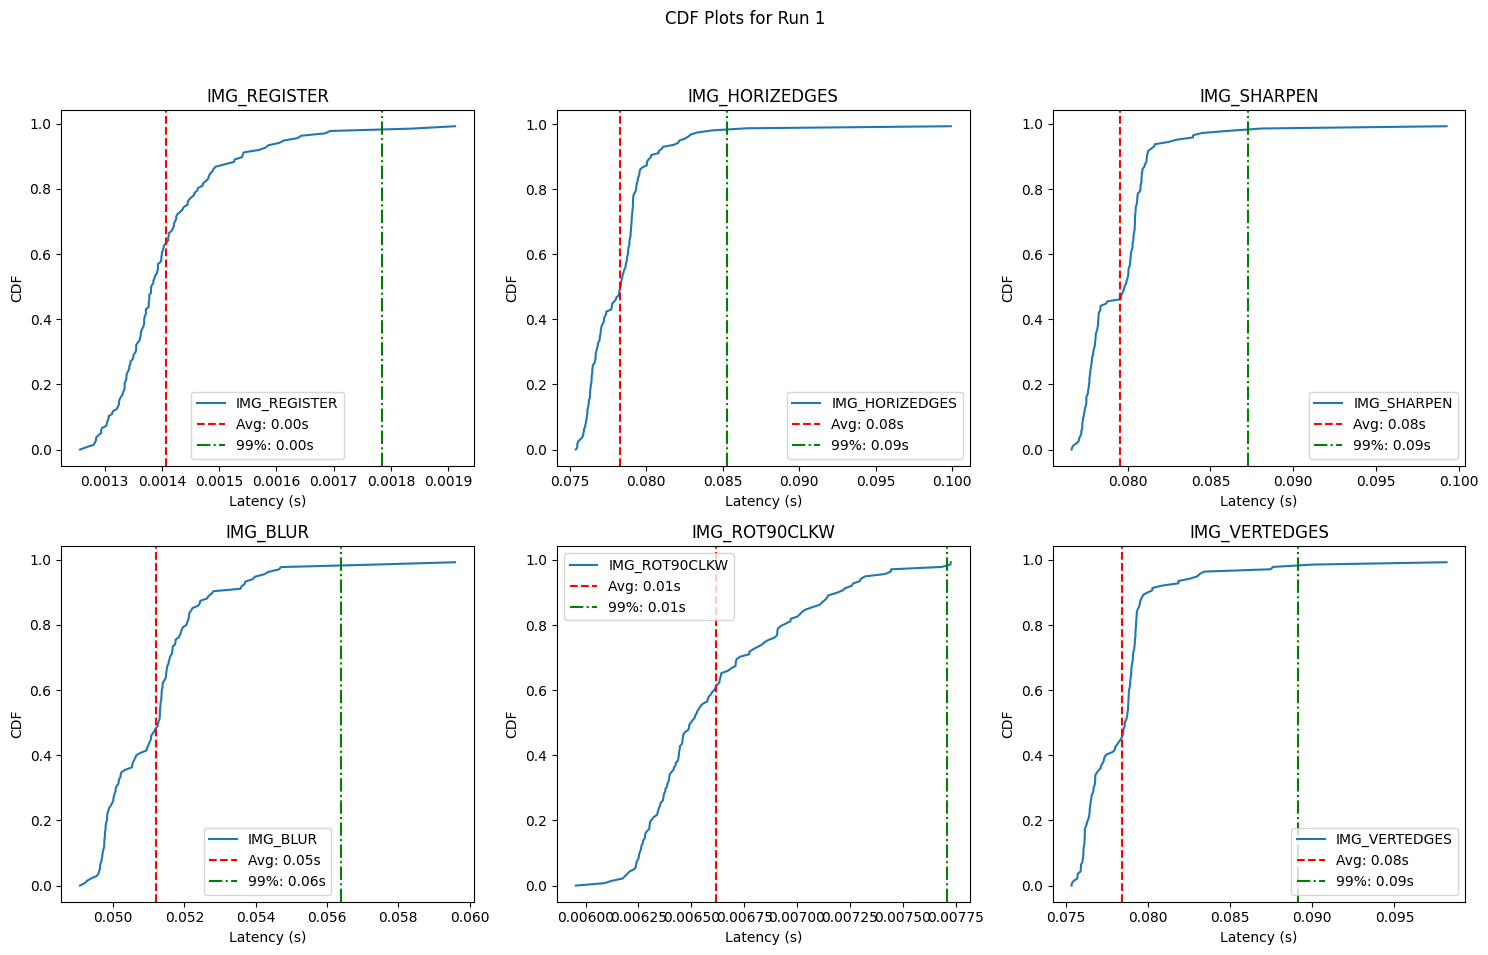

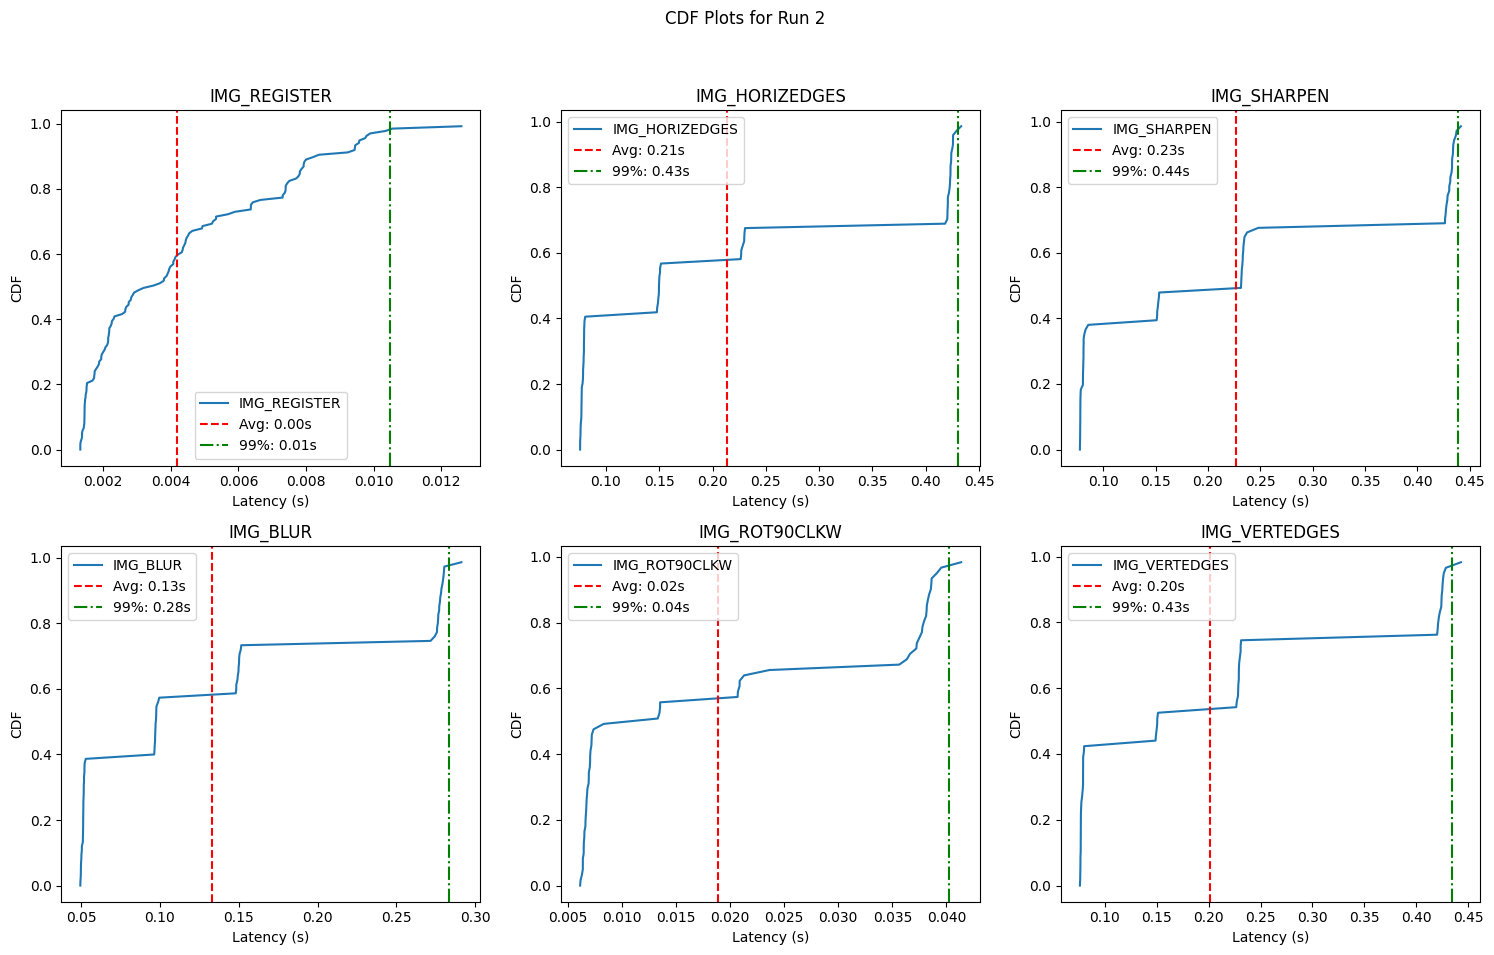

Statistics for Run 1:
IMG_REGISTER: Avg Latency = 0.00s, 99% Tail Latency = 0.00s, Std Deviation = 0.00s
IMG_HORIZEDGES: Avg Latency = 0.08s, 99% Tail Latency = 0.09s, Std Deviation = 0.00s
IMG_SHARPEN: Avg Latency = 0.08s, 99% Tail Latency = 0.09s, Std Deviation = 0.00s
IMG_BLUR: Avg Latency = 0.05s, 99% Tail Latency = 0.06s, Std Deviation = 0.00s
IMG_ROT90CLKW: Avg Latency = 0.01s, 99% Tail Latency = 0.01s, Std Deviation = 0.00s
IMG_VERTEDGES: Avg Latency = 0.08s, 99% Tail Latency = 0.09s, Std Deviation = 0.00s


Statistics for Run 2:
IMG_REGISTER: Avg Latency = 0.00s, 99% Tail Latency = 0.01s, Std Deviation = 0.00s
IMG_HORIZEDGES: Avg Latency = 0.21s, 99% Tail Latency = 0.43s, Std Deviation = 0.15s
IMG_SHARPEN: Avg Latency = 0.23s, 99% Tail Latency = 0.44s, Std Deviation = 0.15s
IMG_BLUR: Avg Latency = 0.13s, 99% Tail Latency = 0.28s, Std Deviation = 0.09s
IMG_ROT90CLKW: Avg Latency = 0.02s, 99% Tail Latency = 0.04s, Std Deviation = 0.01s
IMG_VERTEDGES: Avg Latency = 0.20s, 99% Tail

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import re

def parse_logs(log_file):
    operations_data = {}
    with open(log_file, 'r') as file:
        for line in file:
            # Skip lines corresponding to IMG_RETRIEVE
            if 'IMG_RETRIEVE' in line:
                continue

            # Extract data using regex
            match = re.search(r'(\w+),(\d+),(\d+),(\d+),(\d+.\d+),(\d+.\d+),(\d+.\d+)', line)
            if match:
                operation = match.group(1)
                start_timestamp = float(match.group(6))
                complete_timestamp = float(match.group(7))
                latency = complete_timestamp - start_timestamp

                if operation not in operations_data:
                    operations_data[operation] = []
                operations_data[operation].append(latency)
    return operations_data

def plot_cdf(data, title, ax):
    data_sorted = np.sort(data)
    cdf = np.arange(len(data)) / float(len(data))
    ax.plot(data_sorted, cdf, label=title)
    # Adding lines for average and 99% tail latency
    avg_latency = np.mean(data)
    tail_latency = np.percentile(data, 99)
    ax.axvline(x=avg_latency, color='r', linestyle='--', label=f'Avg: {avg_latency:.2f}s')
    ax.axvline(x=tail_latency, color='g', linestyle='-.', label=f'99%: {tail_latency:.2f}s')
    ax.legend()

def generate_plots(operations_data, run_name):
    plt.figure(figsize=(15, 10))
    stats = {}

    for i, (operation, latencies) in enumerate(operations_data.items()):
        ax = plt.subplot(2, 3, i + 1)
        plot_cdf(latencies, operation, ax)
        plt.xlabel('Latency (s)')
        plt.ylabel('CDF')
        plt.title(operation)

        # Calculate statistics
        avg_latency = np.mean(latencies)
        tail_latency = np.percentile(latencies, 99)
        std_deviation = np.std(latencies)
        stats[operation] = (avg_latency, tail_latency, std_deviation)

    plt.suptitle(f'CDF Plots for {run_name}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'{run_name}_cdf_plots.png')
    plt.show()

    return stats

# Parse the log files and generate the CDF plots for each run
operations_data_run1 = parse_logs('RUN1.txt')
operations_data_run2 = parse_logs('RUN2.txt')

stats_run1 = generate_plots(operations_data_run1, 'Run 1')
stats_run2 = generate_plots(operations_data_run2, 'Run 2')

# Print numerical results for each run
def print_stats(stats, run_name):
    print(f"Statistics for {run_name}:")
    for operation, (avg, tail, std_dev) in stats.items():
        print(f"{operation}: Avg Latency = {avg:.2f}s, 99% Tail Latency = {tail:.2f}s, Std Deviation = {std_dev:.2f}s")
    print("\n")

print_stats(stats_run1, 'Run 1')
print_stats(stats_run2, 'Run 2')


In [22]:
import numpy as np

# Initialize the dictionary to hold the estimators and counts for each operation
ewma_estimators = {}
alpha = 0.7
misprediction_errors = {}

# Function to update the EWMA estimator given the new sample
def update_ewma(ewma, new_sample, alpha):
    return alpha * new_sample + (1 - alpha) * ewma if ewma is not None else new_sample

# Function to process the operations
def process_operations(operations_data):
    for operation, latencies in operations_data.items():
        ewma = None  # Initial EWMA estimate
        errors = []  # List to keep track of misprediction errors for this operation
        
        for latency in latencies:
            # Update the EWMA estimator with the new sample
            if ewma is not None:  # Skip the update for the first sample
                errors.append(abs(ewma - latency))  # Calculate the misprediction error
            ewma = update_ewma(ewma, latency, alpha)
        
        # Store the final EWMA estimator and the average misprediction error for the operation
        ewma_estimators[operation] = ewma
        misprediction_errors[operation] = np.mean(errors) if errors else None

# Assuming operations_data_run2 is populated with the parsed log data for Run 2
process_operations(operations_data_run2)

# Print the EWMA estimators and the average misprediction error for each operation
for operation in ewma_estimators:
    print(f"Operation: {operation}")
    print(f"EWMA Estimator: {ewma_estimators[operation]:.4f}")
    if misprediction_errors[operation] is not None:
        print(f"Average Misprediction Error: {misprediction_errors[operation]:.4f}")
    else:
        print("Average Misprediction Error: N/A (not enough data)")
    print()


Operation: IMG_REGISTER
EWMA Estimator: 0.0031
Average Misprediction Error: 0.0028

Operation: IMG_HORIZEDGES
EWMA Estimator: 0.0861
Average Misprediction Error: 0.1359

Operation: IMG_SHARPEN
EWMA Estimator: 0.2315
Average Misprediction Error: 0.1517

Operation: IMG_BLUR
EWMA Estimator: 0.2648
Average Misprediction Error: 0.0862

Operation: IMG_ROT90CLKW
EWMA Estimator: 0.0111
Average Misprediction Error: 0.0135

Operation: IMG_VERTEDGES
EWMA Estimator: 0.0880
Average Misprediction Error: 0.1372



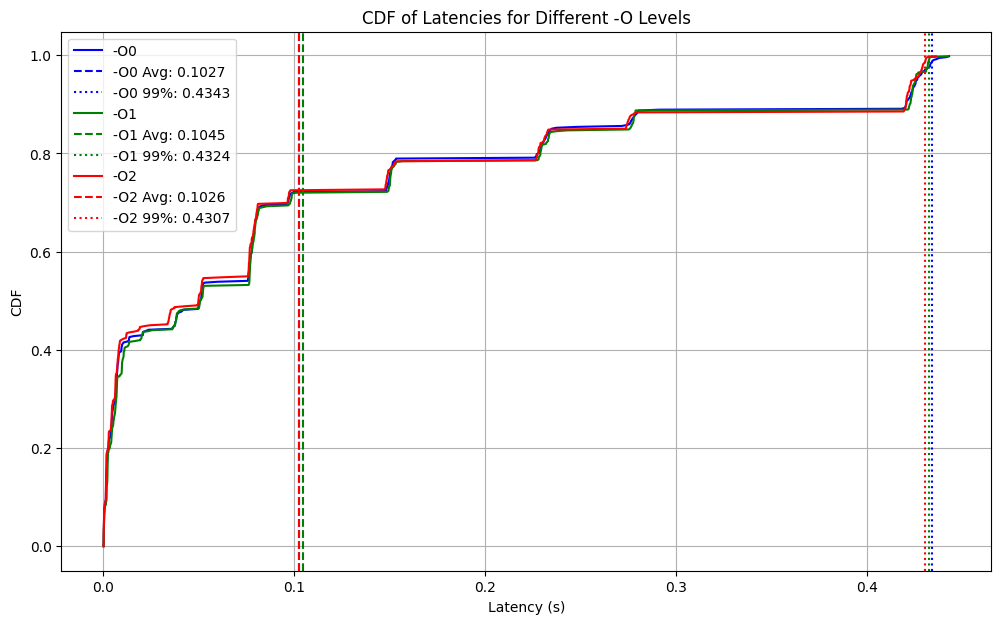

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import re

def new_parse_logs(log_file):
    latencies = []
    with open(log_file, 'r') as file:
        for line in file:
            match = re.search(r'(\d+.\d+),(\d+.\d+),(\d+.\d+)$', line)
            if match:
                # Extract start and complete timestamps
                start_timestamp = float(match.group(2))
                complete_timestamp = float(match.group(3))
                # Calculate the latency
                latency = complete_timestamp - start_timestamp
                latencies.append(latency)
    return latencies

def plot_cdf(data, label, color):
    sorted_data = np.sort(data)
    cdf = np.arange(len(data)) / float(len(data))
    plt.plot(sorted_data, cdf, label=label, color=color)
    # Plot average and 99% tail latency
    plt.axvline(x=np.mean(data), color=color, linestyle='--', label=f'{label} Avg: {np.mean(data):.4f}')
    plt.axvline(x=np.percentile(data, 99), color=color, linestyle=':', label=f'{label} 99%: {np.percentile(data, 99):.4f}')

latencies_O0 = new_parse_logs('RUN2.txt')
latencies_O1 = new_parse_logs('RUN2-O1.txt')
latencies_O2 = new_parse_logs('RUN2-O2.txt')

plt.figure(figsize=(12, 7))
plot_cdf(latencies_O0, '-O0', 'blue')
plot_cdf(latencies_O1, '-O1', 'green')
plot_cdf(latencies_O2, '-O2', 'red')
    
plt.xlabel('Latency (s)')
plt.ylabel('CDF')
plt.title('CDF of Latencies for Different -O Levels')
plt.legend()
plt.grid(True)

plt.savefig('optimization_levels_cdf.png')
plt.show()
